# Extract State Farm auto territory table 

Author: Mo Al Elew

**What notebook does/produces:**

Extracts territory rate setting tables from Auto Club filing PDFs and produces data files for analysis

**Issue/problem being solved:**

- Table is stored in a PDF

**Strategy to solve:**

General pattern:

1. Extract table data from PDF
2. Clean and process the data into a standardized format
3. Run any necessary caclulations to produce location effect figure
4. Match on geographic and demographic data
5. Determine nearest neighbor with lowest base rate

**Sources:**

- data.census.gov
- https://www2.census.gov/geo/tiger/TIGER2020/
- System for Electronic Rates and Forms Filing (SERFF)


In [1]:
import os
import zipfile
from pathlib import Path

import geopandas as gpd
import pandas as pd
import stringcase
import tabula

# Constants and helper func

In [2]:
PDF_FP = "./inputs/MI_Auto_LRF_Effective_2023-04-11.pdf"
MUNICIPAL_BOUND_GIS_FP = "./inputs/Municipal_Boundaries.zip"
DEMOGRAPHIC_GIS_FP = "../01_demographics/outputs/tract_demographics_map.geojson"
BG_FP = "../01_demographics/outputs/bg_demographics_map.geojson"

UNPROCESSED_EXPORT_FP = "./outputs/rate_table.csv"
PROCESSED_EXPORT_FP = "./outputs/statefarm_auto.csv"
PROCESSED_GIS_EXPORT = "./outputs/statefarm_auto_gis.geojson"
CLEAN_EXPORT_FP = "./outputs/statefarm_auto_clean.csv"
CLEAN_MAP_EXPORT_FP = "./outputs/statefarm_auto_clean.geojson"

In [3]:
PAGE_COUNT = 3683
BATCH_STEP = 100

MUNICIPALITIES_TO_EXTRACT = ["Detroit"]
PROJECTED_CRS = "EPSG:3078"

COMPANY_NAME = "State Farm"
VEHICLE_TYPE = "Auto"
FACTOR_CIRCUMVENTED = "zip"
FACTOR_NAME = "Location Factor"
GEOGRAPHY_FACTOR = "GRID ID"
GEOGRAPHY_TYPE = "coordinate"
BG_PREFIX = "bg_"

In [4]:
DETROIT_STREETS = (
    "./inputs/City_of_Detroit_Act51_Map_view_only_588694915804796340.geojson"
)
STREET_EXPORT_FP = "./outputs/eight_mile.geojson"

ROADS_TO_FILTER = ["8 Mile Rd"]
MILE_BUFFER = 3200  # meters

In [5]:
BASE_COLUMNS = [
    "company",
    "vehicle_type",
    "factor_circumvented",
    "factor_name",
    "geography_factor",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "county_fips",
    "tract_fips",
    "block_group_fips",
    "zip",
    "place_name_fips",
]

BLOCK_GROUP_COLS = [
    "geo_id",
    "tot_pop",
    "white_tot",
    "black_tot",
    "white_pct",
    "black_pct",
    "median_income",
    "geometry",
]

DEMOGRAPHIC_COLUMNS_TO_MERGE = [
    "geo_id",
    "geo_name",
    "total_pop",
    "white_tot",
    "black_tot",
    "latin_pct",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "nhpi_pct",
    "other_pct",
    "two_plus_pct",
    "median_income",
    "density",
    "geometry",
]

JOINED_GEO_COLUMNS = [
    "bg_geo_id",
    "bg_tot_pop",
    "bg_white_pct",
    "bg_black_pct",
    "bg_median_income",
    "county_name",
    "city_fips",
    "city_name",
    "is_in_detroit",
    "is_along_8_mile",
    "is_south_8_mile",
    "is_north_8_mile",
]

CLEAN_EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "total_pop",
    "white_pct",
    "black_pct",
    "white_tot",
    "black_tot",
    "median_income",
    "generic_location_based_premium",
    "location_effect",
    "bg_geo_id",
    "bg_tot_pop",
    "bg_white_tot",
    "bg_black_tot",
    "bg_white_pct",
    "bg_black_pct",
    "bg_median_income",
    "is_in_detroit",
    "is_along_8_mile",
    "is_south_8_mile",
    "is_north_8_mile",
    "density",
]

base rate from https://www.documentcloud.org/documents/24410326-mi-at-2022-01-01-complete-manual-state-farm-auto#document/p258/a2426623

In [6]:
BASE_RATE = {
    "BI": 419.6,
    "COLL": 1848.7,
    "COMP": 801.2,
    "LTDPD": 32.4,  # LPD in the base rates table but ltdpd in the territory table
    "PD": 42.7,
    "PIP": 3586.4,
    "PPI": 97.1,
}

In [7]:
RATE_PREFIX = "rate_"


def get_rate_columns(df_rate_table):
    return [col for col in df_rate_table.columns if col.startswith(RATE_PREFIX)]


def get_avg_rate_factor(df_rate_table):
    rate_cols = get_rate_columns(df_rate_table)
    return df_rate_table[rate_cols].mean(axis=1)

In [8]:
def set_first_row_as_header(df):
    df.columns = df.iloc[0]
    return df[1:]

# Read data

Note: There are additional data files read in this notebook. Those files are read in their respective sections due to their being numerous geography identifier joined to the processed data set.

## GRID ID table

In [9]:
def read_table(page_list):
    col2str = {"dtype": str}
    kwargs = {"pandas_options": col2str}
    tables = tabula.read_pdf(PDF_FP, pages=page_list, stream=True, **kwargs)
    return pd.concat([set_first_row_as_header(table) for table in tables])

In [10]:
if Path(UNPROCESSED_EXPORT_FP).is_file():
    DF_GRID_IDS = pd.read_csv(UNPROCESSED_EXPORT_FP, dtype={"GRID ID": str})

else:
    tables = []
    page_steps = list(range(1, PAGE_COUNT, BATCH_STEP)) + [PAGE_COUNT]
    for idx, page in enumerate(page_steps):
        if idx + 1 < len(page_steps):
            pages = list(range(page, page_steps[idx + 1]))
            tables.append(read_table(pages))
    DF_GRID_IDS = pd.concat(tables)

DF_GRID_IDS

,GRID ID,BI_FCTR,COLL_FCTR,COMP_FCTR,LTDPD_FCTR,PD_FCTR,PIP_FCTR,PPI_FCTR
0,0416908441,0.717,0.808,1.795,0.664,0.802,0.711,0.802
1,0416908442,0.717,0.808,1.768,0.664,0.802,0.711,0.802
2,0416908443,0.717,0.808,1.777,0.664,0.802,0.696,0.802
3,0416908444,0.717,0.808,1.750,0.664,0.802,0.711,0.802
4,0416908445,0.717,0.808,1.750,0.664,0.802,0.711,0.802
...,...,...,...,...,...,...,...,...
176720,0481908842,0.973,0.886,1.262,0.855,0.987,0.956,0.987
176721,0481908843,0.802,0.908,1.269,0.842,0.839,0.812,0.839
176722,0481908844,0.802,0.908,1.269,0.842,0.839,0.812,0.839
176723,0482008833,0.802,0.908,1.269,0.842,0.839,0.812,0.839


## Detroit city boundaries

In [11]:
GDF_MUNICIPAL = gpd.read_file(MUNICIPAL_BOUND_GIS_FP)
gdf_detroit = GDF_MUNICIPAL[GDF_MUNICIPAL["NAME"].isin(MUNICIPALITIES_TO_EXTRACT)]

# Build processed table

In [12]:
df_processed_table = DF_GRID_IDS.copy()
print(f"There are {len(df_processed_table)} entries in the GRID ID table")

There are 176725 entries in the GRID ID table


## Rename columns

In [13]:
def create_rate_label(col_name):
    return RATE_PREFIX + stringcase.snakecase(col_name.lower()).replace("___", "_")


def rename_rate_columns(df):
    rate_col_names = df.columns[1:]
    extracted_rate_col_names = [
        create_rate_label(col_name) for col_name in rate_col_names
    ]
    rate_col_renames = dict(zip(rate_col_names, extracted_rate_col_names))
    return df.rename(columns=rate_col_renames)


df_processed_table = rename_rate_columns(df_processed_table)
df_processed_table

,GRID ID,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_ltdpd_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr
0,0416908441,0.717,0.808,1.795,0.664,0.802,0.711,0.802
1,0416908442,0.717,0.808,1.768,0.664,0.802,0.711,0.802
2,0416908443,0.717,0.808,1.777,0.664,0.802,0.696,0.802
3,0416908444,0.717,0.808,1.750,0.664,0.802,0.711,0.802
4,0416908445,0.717,0.808,1.750,0.664,0.802,0.711,0.802
...,...,...,...,...,...,...,...,...
176720,0481908842,0.973,0.886,1.262,0.855,0.987,0.956,0.987
176721,0481908843,0.802,0.908,1.269,0.842,0.839,0.812,0.839
176722,0481908844,0.802,0.908,1.269,0.842,0.839,0.812,0.839
176723,0482008833,0.802,0.908,1.269,0.842,0.839,0.812,0.839


## Calculate base rates

In [14]:
rate_col_names = list(df_processed_table.columns[1:])
base_rate = {
    create_rate_label(coverage_name) + "_fctr": base_rate_val
    for coverage_name, base_rate_val in BASE_RATE.items()
}
df_processed_table[rate_col_names] = df_processed_table[rate_col_names].astype(float)
for col in rate_col_names:
    df_processed_table[col] = df_processed_table[col] * base_rate[col]
df_processed_table

,GRID ID,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_ltdpd_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr
0,0416908441,300.8532,1493.7496,1438.1540,21.5136,34.2454,2549.9304,77.8742
1,0416908442,300.8532,1493.7496,1416.5216,21.5136,34.2454,2549.9304,77.8742
2,0416908443,300.8532,1493.7496,1423.7324,21.5136,34.2454,2496.1344,77.8742
3,0416908444,300.8532,1493.7496,1402.1000,21.5136,34.2454,2549.9304,77.8742
4,0416908445,300.8532,1493.7496,1402.1000,21.5136,34.2454,2549.9304,77.8742
...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,27.7020,42.1449,3428.5984,95.8377
176721,0481908843,336.5192,1678.6196,1016.7228,27.2808,35.8253,2912.1568,81.4669
176722,0481908844,336.5192,1678.6196,1016.7228,27.2808,35.8253,2912.1568,81.4669
176723,0482008833,336.5192,1678.6196,1016.7228,27.2808,35.8253,2912.1568,81.4669


## Aggregate property damage

I combine limited property damage and property damage together into a single property damage base rate. This is completed since the written premium data we are using to weight the data only has a property damage category that likely has the two combined.

In [15]:
df_processed_table["rate_pd_fctr"] = (
    df_processed_table["rate_pd_fctr"] + df_processed_table["rate_ltdpd_fctr"]
)
df_processed_table = df_processed_table.drop(["rate_ltdpd_fctr"], axis=1)
df_processed_table

,GRID ID,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr
0,0416908441,300.8532,1493.7496,1438.1540,55.7590,2549.9304,77.8742
1,0416908442,300.8532,1493.7496,1416.5216,55.7590,2549.9304,77.8742
2,0416908443,300.8532,1493.7496,1423.7324,55.7590,2496.1344,77.8742
3,0416908444,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742
4,0416908445,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742
...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669


## Aggregate rate columns

In [16]:
df_processed_table["generic_location_based_premium"] = round(
    df_processed_table[get_rate_columns(df_processed_table)].sum(axis=1), 2
)
df_processed_table

,GRID ID,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium
0,0416908441,300.8532,1493.7496,1438.1540,55.7590,2549.9304,77.8742,5916.32
1,0416908442,300.8532,1493.7496,1416.5216,55.7590,2549.9304,77.8742,5894.69
2,0416908443,300.8532,1493.7496,1423.7324,55.7590,2496.1344,77.8742,5848.10
3,0416908444,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27
4,0416908445,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27
...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59


## Calculate location effect

In [17]:
median_loc_base_rate = df_processed_table["generic_location_based_premium"].median()
df_processed_table["location_effect"] = round(
    df_processed_table["generic_location_based_premium"] / median_loc_base_rate, 2
)

In [18]:
rate_col_names = list(df_processed_table.columns[1:])

## Geography columns

Rename geography index column 

In [19]:
df_processed_table = df_processed_table.rename(
    columns={"GRID ID": "geography_factor_id"}
)
df_processed_table

,geography_factor_id,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium,location_effect
0,0416908441,300.8532,1493.7496,1438.1540,55.7590,2549.9304,77.8742,5916.32,0.96
1,0416908442,300.8532,1493.7496,1416.5216,55.7590,2549.9304,77.8742,5894.69,0.95
2,0416908443,300.8532,1493.7496,1423.7324,55.7590,2496.1344,77.8742,5848.10,0.95
3,0416908444,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27,0.95
4,0416908445,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27,0.95
...,...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62,1.08
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99


Set geography values

In [20]:
def get_gis(loc):
    mid_point = len(loc) // 2
    coords = [loc[:mid_point], loc[mid_point:]]
    coords = [float(coord) / 100 for coord in coords]
    coords = [coords[0], -1 * coords[1]]
    return pd.Series(coords)


df_processed_table[["latitude", "longitude"]] = df_processed_table[
    "geography_factor_id"
].apply(get_gis)
df_processed_table

,geography_factor_id,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium,location_effect,latitude,longitude
0,0416908441,300.8532,1493.7496,1438.1540,55.7590,2549.9304,77.8742,5916.32,0.96,41.69,-84.41
1,0416908442,300.8532,1493.7496,1416.5216,55.7590,2549.9304,77.8742,5894.69,0.95,41.69,-84.42
2,0416908443,300.8532,1493.7496,1423.7324,55.7590,2496.1344,77.8742,5848.10,0.95,41.69,-84.43
3,0416908444,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27,0.95,41.69,-84.44
4,0416908445,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27,0.95,41.69,-84.45
...,...,...,...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62,1.08,48.19,-88.42
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,-88.43
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,-88.44
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.20,-88.33


## Fill constants

In [21]:
df_processed_table["company"] = COMPANY_NAME
df_processed_table["vehicle_type"] = VEHICLE_TYPE
df_processed_table["factor_circumvented"] = FACTOR_CIRCUMVENTED
df_processed_table["factor_name"] = FACTOR_NAME
df_processed_table["geography_factor"] = GEOGRAPHY_FACTOR
df_processed_table["geography_type"] = GEOGRAPHY_TYPE

In [22]:
def fill_null_columns(df, base_columns):
    base_col_to_fill = list(set(base_columns) - set(df.columns))
    df[base_col_to_fill] = None
    return df


df_processed_table = fill_null_columns(df_processed_table, BASE_COLUMNS)
df_processed_table

,geography_factor_id,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium,location_effect,latitude,...,vehicle_type,factor_circumvented,factor_name,geography_factor,geography_type,tract_fips,block_group_fips,zip,county_fips,place_name_fips
0,0416908441,300.8532,1493.7496,1438.1540,55.7590,2549.9304,77.8742,5916.32,0.96,41.69,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
1,0416908442,300.8532,1493.7496,1416.5216,55.7590,2549.9304,77.8742,5894.69,0.95,41.69,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
2,0416908443,300.8532,1493.7496,1423.7324,55.7590,2496.1344,77.8742,5848.10,0.95,41.69,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
3,0416908444,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27,0.95,41.69,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
4,0416908445,300.8532,1493.7496,1402.1000,55.7590,2549.9304,77.8742,5880.27,0.95,41.69,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62,1.08,48.19,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.20,...,Auto,zip,Location Factor,GRID ID,coordinate,None,None,None,None,None


# Join geographic and demographic data with insurance tables


## Tracts

In [23]:
GDF_DEMOGRAPHICS = gpd.read_file(DEMOGRAPHIC_GIS_FP)
GDF_DEMOGRAPHICS["density"] = (
    GDF_DEMOGRAPHICS["total_pop"] / GDF_DEMOGRAPHICS.to_crs(PROJECTED_CRS).area
)
gdf_demographics = GDF_DEMOGRAPHICS[DEMOGRAPHIC_COLUMNS_TO_MERGE].copy()
gdf_demographics.head()

,geo_id,geo_name,total_pop,white_tot,black_tot,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct,median_income,density,geometry
0,26163591900,Census Tract 5919; Wayne County; Michigan,5610,5044,169,2.3,89.9,3.0,0.2,0.0,0.0,0.0,4.7,69310,0.001115,"POLYGON ((-83.24385 42.08143, -83.24375 42.081..."
1,26163592000,Census Tract 5920; Wayne County; Michigan,4739,3927,257,5.4,82.9,5.4,0.0,3.7,0.0,0.0,2.6,101250,0.000283,"POLYGON ((-83.23187 42.07831, -83.23075 42.079..."
2,26163593200,Census Tract 5932; Wayne County; Michigan,3742,3116,133,8.5,83.3,3.6,0.0,2.4,0.0,0.0,2.2,81444,0.001821,"POLYGON ((-83.25654 42.15356, -83.25327 42.153..."
3,26163594000,Census Tract 5940; Wayne County; Michigan,2405,2137,158,3.8,88.9,6.6,0.0,0.0,0.0,0.0,0.7,64917,0.000463,"POLYGON ((-83.18951 42.14131, -83.18868 42.142..."
4,26163594100,Census Tract 5941; Wayne County; Michigan,4287,3965,2,5.3,92.5,0.0,0.0,1.7,0.0,0.0,0.4,70362,0.001730,"POLYGON ((-83.20697 42.14824, -83.20675 42.150..."


In [24]:
gdf_rate_table = gpd.GeoDataFrame(
    df_processed_table,
    geometry=gpd.points_from_xy(
        df_processed_table["longitude"], df_processed_table["latitude"]
    ),
)

In [25]:
gdf_rate_table_demographics_joined = gdf_rate_table.sjoin(
    gdf_demographics, how="inner", predicate="intersects"
)
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.drop(
    "index_right", axis=1
)
gdf_rate_table_demographics_joined

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,geography_factor_id,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium,location_effect,latitude,...,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct,median_income,density
103,0417008467,317.2176,1536.2697,1600.7976,56.8943,2607.3128,79.7191,6198.21,1.00,41.70,...,0.3,97.4,0.2,0.0,0.0,0.0,0.1,2.0,56047,1.259640e-05
104,0417008468,317.2176,1504.8418,1632.8456,56.8943,2607.3128,79.7191,6198.83,1.00,41.70,...,0.3,97.4,0.2,0.0,0.0,0.0,0.1,2.0,56047,1.259640e-05
105,0417008469,317.2176,1504.8418,1600.7976,56.8943,2607.3128,79.7191,6166.78,1.00,41.70,...,0.3,97.4,0.2,0.0,0.0,0.0,0.1,2.0,56047,1.259640e-05
106,0417008470,317.2176,1504.8418,1575.9604,56.8943,2607.3128,79.7191,6141.95,0.99,41.70,...,0.3,97.4,0.2,0.0,0.0,0.0,0.1,2.0,56047,1.259640e-05
107,0417008471,317.2176,1490.0522,1545.5148,56.8943,2607.3128,79.7191,6096.71,0.99,41.70,...,2.5,94.7,0.2,0.0,0.1,0.0,0.0,2.5,49375,1.956896e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62,1.08,48.19,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,-,8.004833e-10
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,-,8.004833e-10
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,-,8.004833e-10
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.20,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,-,8.004833e-10


## Block group

I merge on Block Group demographics for our nearest neighbor analysis.

In [26]:
GDF_BG = gpd.read_file(BG_FP)
gdf_bg = GDF_BG[BLOCK_GROUP_COLS].copy()
gdf_bg.columns = [BG_PREFIX + col if col != "geometry" else col for col in gdf_bg.columns]
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.sjoin(
    gdf_bg, how="left", predicate="intersects"
)
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.drop(
    "index_right", axis=1
)
gdf_rate_table_demographics_joined

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,geography_factor_id,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium,location_effect,latitude,...,two_plus_pct,median_income,density,bg_geo_id,bg_tot_pop,bg_white_tot,bg_black_tot,bg_white_pct,bg_black_pct,bg_median_income
103,0417008467,317.2176,1536.2697,1600.7976,56.8943,2607.3128,79.7191,6198.21,1.00,41.70,...,2.0,56047,1.259640e-05,260590511001,1063,1047,6,98.5,0.6,56528
104,0417008468,317.2176,1504.8418,1632.8456,56.8943,2607.3128,79.7191,6198.83,1.00,41.70,...,2.0,56047,1.259640e-05,260590511001,1063,1047,6,98.5,0.6,56528
105,0417008469,317.2176,1504.8418,1600.7976,56.8943,2607.3128,79.7191,6166.78,1.00,41.70,...,2.0,56047,1.259640e-05,260590511001,1063,1047,6,98.5,0.6,56528
106,0417008470,317.2176,1504.8418,1575.9604,56.8943,2607.3128,79.7191,6141.95,0.99,41.70,...,2.0,56047,1.259640e-05,260590511001,1063,1047,6,98.5,0.6,56528
107,0417008471,317.2176,1490.0522,1545.5148,56.8943,2607.3128,79.7191,6096.71,0.99,41.70,...,2.5,49375,1.956896e-05,260590512002,1222,1163,0,95.2,0.0,47563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62,1.08,48.19,...,0.0,-,8.004833e-10,260839801001,2,2,0,100.0,0.0,-
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,0.0,-,8.004833e-10,260839801001,2,2,0,100.0,0.0,-
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,0.0,-,8.004833e-10,260839801001,2,2,0,100.0,0.0,-
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.20,...,0.0,-,8.004833e-10,260839801001,2,2,0,100.0,0.0,-


# Out of state

- Visual verification that points dropped after merge fall out of state bounds
- This was further inspected on QGIS to verify these fall outside of Michigan's state bounds

In [27]:
grid_ids_drop_count = len(DF_GRID_IDS) - len(gdf_rate_table_demographics_joined)
print(f"{grid_ids_drop_count} points were dropped due to falling outside state bounds")

1289 points were dropped due to falling outside state bounds


<Axes: >

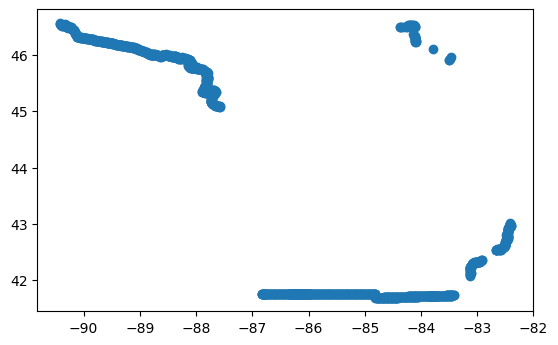

In [28]:
gdf_out_of_state = gdf_rate_table[
    ~gdf_rate_table["geography_factor_id"].isin(
        gdf_rate_table_demographics_joined["geography_factor_id"]
    )
]
gdf_out_of_state.plot()

# Join geographic identifiers

For the following section, we merge on the geographic identifiers for different geographies. 

## County

In [29]:
COUNTY_FP = "../01_demographics/outputs/county_demographics_map.geojson"
GDF_COUNTY = gpd.read_file(COUNTY_FP)
gdf_county = GDF_COUNTY[["geo_id", "namelsad", "geometry"]].copy()
gdf_county.columns = ["county_fips", "county_name", "geometry"]
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.sjoin(
    gdf_county, how="left", predicate="intersects"
)
gdf_rate_table_demographics_joined["county_fips"] = gdf_rate_table_demographics_joined[
    "county_fips_right"
]
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.drop(
    "index_right", axis=1
)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


## City

In [30]:
GDF_CDP_CITY = gpd.read_file(
    "../01_demographics/outputs/city_cdp_demographics_gis.geojson"
)

In [31]:
gdf_cdp_city = GDF_CDP_CITY[["geo_id", "geo_name", "geometry"]].copy()
gdf_cdp_city.columns = ["city_fips", "city_name", "geometry"]
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.sjoin(
    gdf_cdp_city.to_crs("EPSG:4269"), how="left", predicate="intersects"
)
gdf_rate_table_demographics_joined = gdf_rate_table_demographics_joined.drop(
    "index_right", axis=1
)
assert gdf_rate_table_demographics_joined["city_name"].notnull().sum() > 0
gdf_rate_table_demographics_joined

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,geography_factor_id,rate_bi_fctr,rate_coll_fctr,rate_comp_fctr,rate_pd_fctr,rate_pip_fctr,rate_ppi_fctr,generic_location_based_premium,location_effect,latitude,...,bg_white_tot,bg_black_tot,bg_white_pct,bg_black_pct,bg_median_income,county_fips_right,county_name,county_fips,city_fips,city_name
103,0417008467,317.2176,1536.2697,1600.7976,56.8943,2607.3128,79.7191,6198.21,1.00,41.70,...,1047,6,98.5,0.6,56528,26059,Hillsdale County,26059,NaN,NaN
104,0417008468,317.2176,1504.8418,1632.8456,56.8943,2607.3128,79.7191,6198.83,1.00,41.70,...,1047,6,98.5,0.6,56528,26059,Hillsdale County,26059,NaN,NaN
105,0417008469,317.2176,1504.8418,1600.7976,56.8943,2607.3128,79.7191,6166.78,1.00,41.70,...,1047,6,98.5,0.6,56528,26059,Hillsdale County,26059,NaN,NaN
106,0417008470,317.2176,1504.8418,1575.9604,56.8943,2607.3128,79.7191,6141.95,0.99,41.70,...,1047,6,98.5,0.6,56528,26059,Hillsdale County,26059,NaN,NaN
107,0417008471,317.2176,1490.0522,1545.5148,56.8943,2607.3128,79.7191,6096.71,0.99,41.70,...,1163,0,95.2,0.0,47563,26059,Hillsdale County,26059,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176720,0481908842,408.2708,1637.9482,1011.1144,69.8469,3428.5984,95.8377,6651.62,1.08,48.19,...,2,0,100.0,0.0,-,26083,Keweenaw County,26083,NaN,NaN
176721,0481908843,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,2,0,100.0,0.0,-,26083,Keweenaw County,26083,NaN,NaN
176722,0481908844,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.19,...,2,0,100.0,0.0,-,26083,Keweenaw County,26083,NaN,NaN
176723,0482008833,336.5192,1678.6196,1016.7228,63.1061,2912.1568,81.4669,6088.59,0.99,48.20,...,2,0,100.0,0.0,-,26083,Keweenaw County,26083,NaN,NaN


# Detroit filter

In [32]:
gdf_rate_table_demographics_joined.set_crs(epsg=4326, inplace=True)
gdf_detroit_points = list(
    gpd.overlay(gdf_rate_table_demographics_joined, gdf_detroit.to_crs(4326))[
        "geography_factor_id"
    ]
)
gdf_rate_table_demographics_joined["is_in_detroit"] = (
    gdf_rate_table_demographics_joined["geography_factor_id"].isin(gdf_detroit_points)
)

# 8 Mile Rd.

## Read data

In [33]:
GDF_STREETS = gpd.read_file(DETROIT_STREETS)
GDF_STREETS

,FID,RDNAME,Type,Shape__Len,Shape__L_1,Shape_Leng,Shape__L_2,Shape_Le_1,Shape_Le_2,geometry
0,1,8 Mile Rd,MDOT,19.172881,30855.822722,0.0,0.0,41753.788750,41753.788750,"MULTILINESTRING ((-9271553.293 5227502.008, -9..."
1,2,Belle Isle,MDOT,0.000000,0.000000,0.0,0.0,34373.308201,34373.308201,"MULTILINESTRING ((-9239330.499 5211052.758, -9..."
2,3,E Davison St,MDOT,0.000000,0.000000,0.0,0.0,4619.825696,4619.825696,"MULTILINESTRING ((-9248127.272 5222498.142, -9..."
3,4,E Jefferson Ave,MDOT,0.000000,0.000000,0.0,0.0,1667.870198,1667.870198,"MULTILINESTRING ((-9244465.807 5210319.667, -9..."
4,6,Fort St,MDOT,0.000000,0.000000,0.0,0.0,656.713537,656.713537,"LINESTRING (-9256933.078 5202210.539, -9256855..."
...,...,...,...,...,...,...,...,...,...,...
29729,29893,Ford Rd,MDOT,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9263565.162 5210409.198, -9264586..."
29730,29894,Wyoming St,County,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9256982.570 5211583.836, -9256965..."
29731,29895,Margareta St,City Minor,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9269685.351 5224933.985, -9269639..."
29732,29896,St Aubin,City Major,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9245802.270 5218424.497, -9245965..."


## Filter and buffer 8 mile drive

In [34]:
gdf_roads_8_mile = GDF_STREETS[GDF_STREETS["RDNAME"].isin(ROADS_TO_FILTER)].copy()
gdf_roads_8_mile_buffered = gdf_roads_8_mile.copy()
gdf_roads_8_mile_buffered["geometry"] = gdf_roads_8_mile_buffered["geometry"].buffer(
    MILE_BUFFER
)
gdf_roads_8_mile_buffered

,FID,RDNAME,Type,Shape__Len,Shape__L_1,Shape_Leng,Shape__L_2,Shape_Le_1,Shape_Le_2,geometry
0,1,8 Mile Rd,MDOT,19.172881,30855.822722,0.0,0.0,41753.78875,41753.78875,"POLYGON ((-9271637.297 5230697.376, -9271637.3..."


## Filter for rates near 8 mile drive

<Axes: >

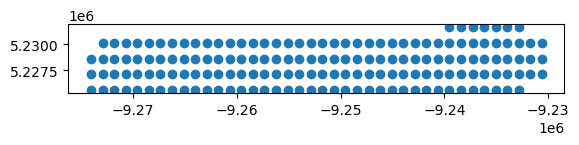

In [35]:
gdf_8_mile_rates = gpd.overlay(
    gdf_rate_table_demographics_joined.to_crs(gdf_roads_8_mile_buffered.crs),
    gdf_roads_8_mile_buffered,
)
gdf_8_mile_rates.plot()

In [36]:
gdf_rate_table_demographics_joined["is_along_8_mile"] = (
    gdf_rate_table_demographics_joined["geography_factor_id"].isin(
        gdf_8_mile_rates["geography_factor_id"]
    )
)

In [37]:
gdf_rate_table_demographics_joined["is_south_8_mile"] = (
    gdf_rate_table_demographics_joined["latitude"] < 42.45
) & gdf_rate_table_demographics_joined["is_along_8_mile"]
gdf_rate_table_demographics_joined["is_north_8_mile"] = (
    ~(gdf_rate_table_demographics_joined["is_south_8_mile"])
    & gdf_rate_table_demographics_joined["is_along_8_mile"]
)

# Export

In [38]:
gdf_roads_8_mile.to_file(STREET_EXPORT_FP)

In [39]:
expected_col_order = BASE_COLUMNS + rate_col_names
df_export = df_processed_table[expected_col_order]
df_export.to_csv(PROCESSED_EXPORT_FP, index=False)
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176725 entries, 0 to 176724
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   company                         176725 non-null  object 
 1   vehicle_type                    176725 non-null  object 
 2   factor_circumvented             176725 non-null  object 
 3   factor_name                     176725 non-null  object 
 4   geography_factor                176725 non-null  object 
 5   geography_type                  176725 non-null  object 
 6   geography_factor_id             176725 non-null  object 
 7   latitude                        176725 non-null  float64
 8   longitude                       176725 non-null  float64
 9   county_fips                     0 non-null       object 
 10  tract_fips                      0 non-null       object 
 11  block_group_fips                0 non-null       object 
 12  zip             

In [40]:
DF_GRID_IDS.to_csv(UNPROCESSED_EXPORT_FP, index=False)
DF_GRID_IDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176725 entries, 0 to 176724
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   GRID ID     176725 non-null  object 
 1   BI_FCTR     176725 non-null  float64
 2   COLL_FCTR   176725 non-null  float64
 3   COMP_FCTR   176725 non-null  float64
 4   LTDPD_FCTR  176725 non-null  float64
 5   PD_FCTR     176725 non-null  float64
 6   PIP_FCTR    176725 non-null  float64
 7   PPI_FCTR    176725 non-null  float64
dtypes: float64(7), object(1)
memory usage: 10.8+ MB


In [41]:
gdf_rate_table_demographics_joined[CLEAN_EXPORT_COLS].to_csv(
    CLEAN_EXPORT_FP, index=False
)
gdf_rate_table_demographics_joined[CLEAN_EXPORT_COLS + ["geometry"]].to_file(
    CLEAN_MAP_EXPORT_FP, driver="GeoJSON"
)

with zipfile.ZipFile(
    "./outputs/statefarm_auto_clean_gis.zip",
    "w",
    compression=zipfile.ZIP_DEFLATED,
    compresslevel=9,
) as zipf:
    zipf.write(
        os.path.join("./outputs/", "statefarm_auto_clean.geojson"),
        arcname="statefarm_auto_clean.geojson",
    )

!rm ./outputs/statefarm_auto_clean.geojson

In [42]:
gdf_export = gdf_rate_table_demographics_joined[
    expected_col_order + JOINED_GEO_COLUMNS + DEMOGRAPHIC_COLUMNS_TO_MERGE
].copy()
gdf_export.to_file(PROCESSED_GIS_EXPORT, driver="GeoJSON")
gdf_export.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 175436 entries, 103 to 176724
Data columns (total 50 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   company                         175436 non-null  object  
 1   vehicle_type                    175436 non-null  object  
 2   factor_circumvented             175436 non-null  object  
 3   factor_name                     175436 non-null  object  
 4   geography_factor                175436 non-null  object  
 5   geography_type                  175436 non-null  object  
 6   geography_factor_id             175436 non-null  object  
 7   latitude                        175436 non-null  float64 
 8   longitude                       175436 non-null  float64 
 9   county_fips                     175435 non-null  object  
 10  tract_fips                      0 non-null       object  
 11  block_group_fips                0 non-null       object  
 1

# Appendix

- Due to the binning, I want to verify that there were no off by one errors resulting in a page being read in multiple times. So i check for duplicate rows.
- I also want to verify the GRID IDs were read in without issue and that the leading zero was not dropped from the coordinate format

In [43]:
assert len(DF_GRID_IDS[DF_GRID_IDS.duplicated()]) == 0
assert (~DF_GRID_IDS["GRID ID"].str.startswith("0")).sum() == 0

In [44]:
assert (df_processed_table["latitude"] <= 10).sum() == 0
assert (df_processed_table["longitude"] > -10).sum() == 0